In [8]:
# Check if curve_db is loaded, if not load it
try:
    curve_db
    print(f"✓ curve_db is already loaded with {len(curve_db)} isogeny classes")
except NameError:
    print("Loading curve database...")
    curve_db = load('Curve Database (Conductor < 100 000)/curve_database_c1_to_100000.sobj')
    print(f"✓ Loaded curve_db with {len(curve_db)} isogeny classes")
print()

Loading curve database...
✓ Loaded curve_db with 437226 isogeny classes



In [39]:
import os
import traceback
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from collections import defaultdict
from sage.all import save

def process_phi(n):
    """Worker function to process phi = 1/n"""
    try:
        from sage.all import QQ, EllipticCurve
        
        phi = 1/n
        
        a = -(9*phi**4 - 12*phi**3 + 30*phi**2 - 12*phi + 1) / 3
        b = -2*(27*phi**6 - 54*phi**5 - 135*phi**4 + 180*phi**3 - 99*phi**2 + 18*phi - 1) / 27
        
        E = EllipticCurve([0, 0, 0, a, b])
        label = E.label()
        
        # Extract isogeny class
        i = len(label) - 1
        while i >= 0 and label[i].isdigit():
            i -= 1
        iso_class = label[:i+1]
        
        return (n, iso_class, None)
    except Exception as e:
        return (n, None, f"{type(e).__name__}: {str(e)}")

nmax = int(1e4)
n_values = list(range(-nmax, nmax))
n_values = [x for x in n_values if x != 0]

print(f"Scanning phi = 1/n for n in [{n_values[0]}, {n_values[-1]}]")
print(f"Using {cpu_count()} CPU cores")

with Pool(processes=cpu_count()) as pool:
    results = list(tqdm(
        pool.imap(process_phi, n_values, chunksize=10),
        total=len(n_values),
        desc='Retrieving isogeny classes'
    ))

# Build mapping: isogeny class -> list of n values
iso_to_n = defaultdict(list)
failures = {}  # n -> error message

for n, iso_class, error in results:
    if iso_class is not None:
        iso_to_n[iso_class].append(n)
    else:
        failures[n] = error

# Convert to regular dict and sort n values
iso_to_n = {k: sorted(v) for k, v in iso_to_n.items()}

num_valid = sum(len(v) for v in iso_to_n.values())
num_unique = len(iso_to_n)

print(f"\nResults:")
print(f"  Total phis tested: {len(n_values)}")
print(f"  Phis yielding isogeny classes: {num_valid} ({int(100)*num_valid/len(n_values):.2f}%)")
print(f"  Unique isogeny classes found: {num_unique}")
if num_unique > 0:
    print(f"  Average multiplicity: {num_valid/num_unique:.2f}")

# Summarize errors by type
if failures:
    error_counts = defaultdict(int)
    for err in failures.values():
        error_type = err.split(":")[0]
        error_counts[error_type] += 1
    print(f"\nFailures by error type:")
    for err_type, count in sorted(error_counts.items(), key=lambda x: -x[1]):
        print(f"  {err_type}: {count}")

# Save results
output_dir = "phi_scan_optimization"
os.makedirs(output_dir, exist_ok=True)

# Save full mapping with Sage
save(iso_to_n, os.path.join(output_dir, "iso_to_n"))

# Save failures with error messages
if failures:
    save(failures, os.path.join(output_dir, "failures"))

# Save summary sorted by multiplicity (human-readable)
summary = sorted(iso_to_n.items(), key=lambda x: len(x[1]), reverse=True)
with open(os.path.join(output_dir, "summary.txt"), "w") as f:
    f.write(f"Scan: phi = 1/n for n in [{n_values[0]}, {n_values[-1]}]\n")
    f.write(f"Total phis tested: {len(n_values)}\n")
    f.write(f"Phis yielding isogeny classes: {num_valid}\n")
    f.write(f"Unique isogeny classes: {num_unique}\n\n")
    f.write("Isogeny classes by multiplicity:\n")
    f.write("-" * 50 + "\n")
    for iso, n_list in summary:
        f.write(f"{iso}: {len(n_list)} hits, n = {n_list}\n")

# Save failures summary
if failures:
    with open(os.path.join(output_dir, "failures.txt"), "w") as f:
        f.write(f"Failed n values: {len(failures)}\n\n")
        # Group by error type
        by_error = defaultdict(list)
        for n, err in failures.items():
            by_error[err].append(n)
        for err, n_list in sorted(by_error.items(), key=lambda x: -len(x[1])):
            f.write(f"{err}\n  n = {sorted(n_list)}\n\n")

print(f"\nResults saved to {output_dir}/")
print(f"  iso_to_n.sobj  - full mapping (load with load())")
print(f"  summary.txt    - human-readable summary")
if failures:
    print(f"  failures.sobj  - {len(failures)} failures with errors")
    print(f"  failures.txt   - human-readable failure summary")

Scanning phi = 1/n for n in [-10000, 9999]
Using 28 CPU cores


Retrieving isogeny classes: 100%|████████████████████████████████████████████████| 19999/19999 [02:48<00:00, 118.48it/s]



Results:
  Total phis tested: 19999
  Phis yielding isogeny classes: 486 (2.43%)
  Unique isogeny classes found: 480
  Average multiplicity: 1.01

Failures by error type:
  LookupError: 19511
  ArithmeticError: 2

Results saved to phi_scan_optimization/
  iso_to_n.sobj  - full mapping (load with load())
  summary.txt    - human-readable summary
  failures.sobj  - 19513 failures with errors
  failures.txt   - human-readable failure summary


In [174]:
iso_to_n = load('phi_scan_optimization/iso_to_n')

In [189]:
Ns = []
ns = []

for iso in iso_to_n.keys():
    try:
        N = curve_db[iso]['conductor']
        n = iso_to_n[iso]
        if len(n) == 1:
            Ns.append(N)
            ns.append(n[0])
        else:
            Ns.extend([N for _ in range(len(n))])
            ns.extend(n)
    except:
        continue

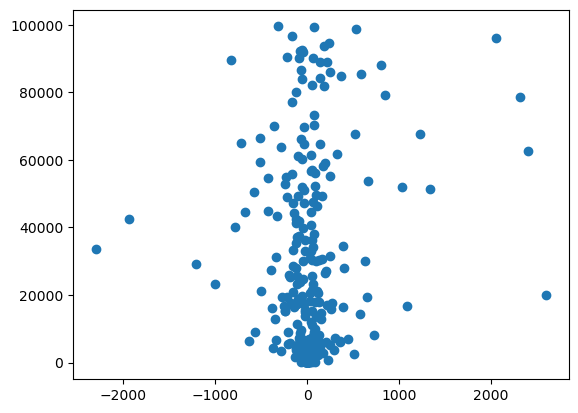

In [11]:
import matplotlib.pyplot as plt

plt.scatter(ns, Ns)
plt.show()

In [111]:
print(ns[0], ns[-1])

-2303 2601


In [129]:
import numpy as np
from tqdm import tqdm

# Compute the CDF

dn = 50
nranges = np.arange(ns[0], ns[-1], dn)
effs = []

for nrange in tqdm(nranges, desc='Computing efficiencies'):
    cnt = 0
    for n in ns:
        if n <= nrange:
            cnt += 1
    eff = cnt/len(ns)*100
    effs.append(eff)

Computing efficiencies: 100%|████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 15662.79it/s]


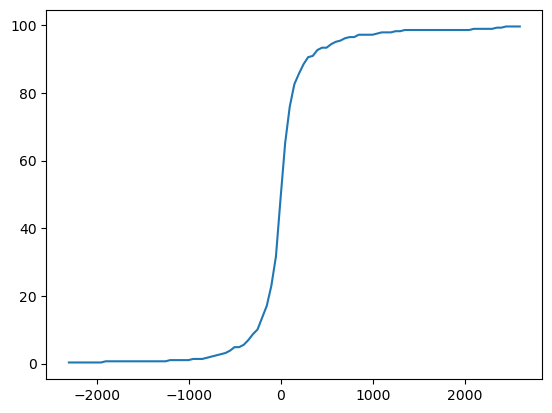

In [130]:
plt.plot(nranges, effs)
plt.show()

In [131]:
# This is the CDF, let's compute the pdf from it: df/dn

pdf = np.diff(effs)/np.array([dn]*(len(effs)-1))

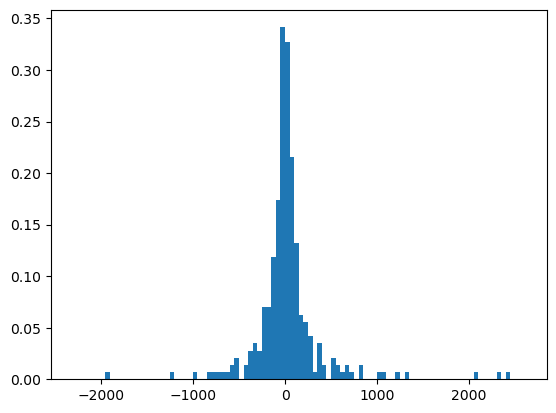

In [132]:
plt.stairs(pdf, nranges, fill=True, edgecolor='black')
plt.show()

Fit parameters: μ=0.288, γ=88.477, A=99.196
Reduced χ² = 0.013


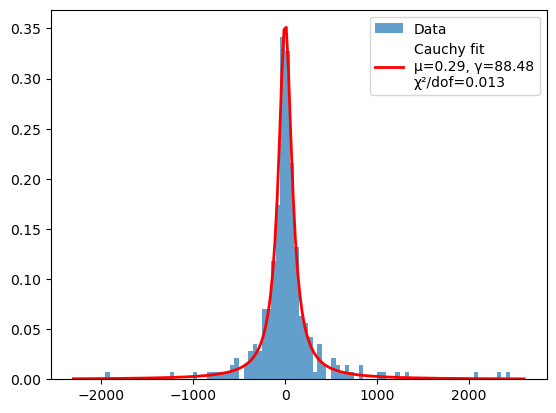

In [133]:
from scipy.optimize import curve_fit
import numpy as np

# Cauchy/Lorentzian PDF
def cauchy(x, A, mu, gamma):
    return A * (gamma / np.pi) / ((x - mu)**2 + gamma**2)

# Bin centers
x = np.array([(nranges[i] + nranges[i+1]) / 2 for i in range(len(nranges) - 1)])
pdf = np.array(pdf)

# Fit
p0 = [max(pdf), 0, 50]
bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])
popt, pcov = curve_fit(cauchy, x, pdf, p0=p0, bounds=bounds)
A, mu, gamma_param = popt

# Reduced chi-squared (uniform weighting)
residuals = pdf - cauchy(x, *popt)
dof = len(pdf) - len(popt)
chi2_red = np.sum(residuals**2) / (dof * np.var(pdf))

print(f"Fit parameters: μ={mu:.3f}, γ={gamma_param:.3f}, A={A:.3f}")
print(f"Reduced χ² = {chi2_red:.3f}")

# Plot
plt.stairs(pdf, nranges, fill=True, edgecolor='black', alpha=0.7, label='Data')
x_fit = np.linspace(nranges[0], nranges[-1], 200)
plt.plot(x_fit, cauchy(x_fit, *popt), 'r-', lw=2, 
         label=f'Cauchy fit\nμ={mu:.2f}, γ={gamma_param:.2f}\nχ²/dof={chi2_red:.3f}')
plt.legend()
plt.show()

In [136]:
import os
import traceback
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from collections import defaultdict
from sage.all import save

# Scan for phi = m

def process_phi(n):
    """Worker function to process phi = 1/n"""
    try:
        from sage.all import QQ, EllipticCurve
        
        phi = n
        
        a = -(9*phi**4 - 12*phi**3 + 30*phi**2 - 12*phi + 1) / 3
        b = -2*(27*phi**6 - 54*phi**5 - 135*phi**4 + 180*phi**3 - 99*phi**2 + 18*phi - 1) / 27
        
        E = EllipticCurve([0, 0, 0, a, b])
        label = E.label()
        
        # Extract isogeny class
        i = len(label) - 1
        while i >= 0 and label[i].isdigit():
            i -= 1
        iso_class = label[:i+1]
        
        return (n, iso_class, None)
    except Exception as e:
        return (n, None, f"{type(e).__name__}: {str(e)}")

nmax = int(1e4)
n_values = list(range(-nmax, nmax))
n_values = [x for x in n_values if x != 0]

print(f"Scanning phi = 1/n for n in [{n_values[0]}, {n_values[-1]}]")
print(f"Using {cpu_count()} CPU cores")

with Pool(processes=cpu_count()) as pool:
    results = list(tqdm(
        pool.imap(process_phi, n_values, chunksize=10),
        total=len(n_values),
        desc='Retrieving isogeny classes'
    ))

# Build mapping: isogeny class -> list of n values
iso_to_n = defaultdict(list)
failures = {}  # n -> error message

for n, iso_class, error in results:
    if iso_class is not None:
        iso_to_n[iso_class].append(n)
    else:
        failures[n] = error

# Convert to regular dict and sort n values
iso_to_n = {k: sorted(v) for k, v in iso_to_n.items()}

num_valid = sum(len(v) for v in iso_to_n.values())
num_unique = len(iso_to_n)

print(f"\nResults:")
print(f"  Total phis tested: {len(n_values)}")
print(f"  Phis yielding isogeny classes: {num_valid} ({int(100)*num_valid/len(n_values):.2f}%)")
print(f"  Unique isogeny classes found: {num_unique}")
if num_unique > 0:
    print(f"  Average multiplicity: {num_valid/num_unique:.2f}")

# Summarize errors by type
if failures:
    error_counts = defaultdict(int)
    for err in failures.values():
        error_type = err.split(":")[0]
        error_counts[error_type] += 1
    print(f"\nFailures by error type:")
    for err_type, count in sorted(error_counts.items(), key=lambda x: -x[1]):
        print(f"  {err_type}: {count}")

# Save results
output_dir = "phi_scan_optimization"
os.makedirs(output_dir, exist_ok=True)

# Save full mapping with Sage
save(iso_to_n, os.path.join(output_dir, "iso_to_m"))

# Save failures with error messages
if failures:
    save(failures, os.path.join(output_dir, "failures"))

# Save summary sorted by multiplicity (human-readable)
summary = sorted(iso_to_n.items(), key=lambda x: len(x[1]), reverse=True)
with open(os.path.join(output_dir, "summary.txt"), "w") as f:
    f.write(f"Scan: phi = m for m in [{n_values[0]}, {n_values[-1]}]\n")
    f.write(f"Total phis tested: {len(n_values)}\n")
    f.write(f"Phis yielding isogeny classes: {num_valid}\n")
    f.write(f"Unique isogeny classes: {num_unique}\n\n")
    f.write("Isogeny classes by multiplicity:\n")
    f.write("-" * 50 + "\n")
    for iso, n_list in summary:
        f.write(f"{iso}: {len(n_list)} hits, n = {n_list}\n")

# Save failures summary
if failures:
    with open(os.path.join(output_dir, "failures.txt"), "w") as f:
        f.write(f"Failed n values: {len(failures)}\n\n")
        # Group by error type
        by_error = defaultdict(list)
        for n, err in failures.items():
            by_error[err].append(n)
        for err, n_list in sorted(by_error.items(), key=lambda x: -len(x[1])):
            f.write(f"{err}\n  n = {sorted(n_list)}\n\n")

print(f"\nResults saved to {output_dir}/")
print(f"  iso_to_m.sobj  - full mapping (load with load())")
print(f"  summary.txt    - human-readable summary")
if failures:
    print(f"  failures.sobj  - {len(failures)} failures with errors")
    print(f"  failures.txt   - human-readable failure summary")

Scanning phi = 1/n for n in [-10000, 9999]
Using 28 CPU cores


Retrieving isogeny classes: 100%|████████████████████████████████████████████████| 19999/19999 [01:59<00:00, 167.28it/s]



Results:
  Total phis tested: 19999
  Phis yielding isogeny classes: 215 (1.08%)
  Unique isogeny classes found: 215
  Average multiplicity: 1.00

Failures by error type:
  LookupError: 19783
  ArithmeticError: 1

Results saved to phi_scan_optimization/
  iso_to_m.sobj  - full mapping (load with load())
  summary.txt    - human-readable summary
  failures.sobj  - 19784 failures with errors
  failures.txt   - human-readable failure summary


In [137]:
iso_to_m = load('phi_scan_optimization/iso_to_m')

In [153]:
Ns = []
ms = []

for iso in list(iso_to_m.keys()):
    try:
        N = curve_db[iso]['conductor']
        m = iso_to_m[iso]
        if len(m) == 1:
            Ns.append(N)
            ms.append(m[0])
        else:
            Ns.extend([N for _ in range(len(m))])
            ms.extend(m)
    except:
        continue

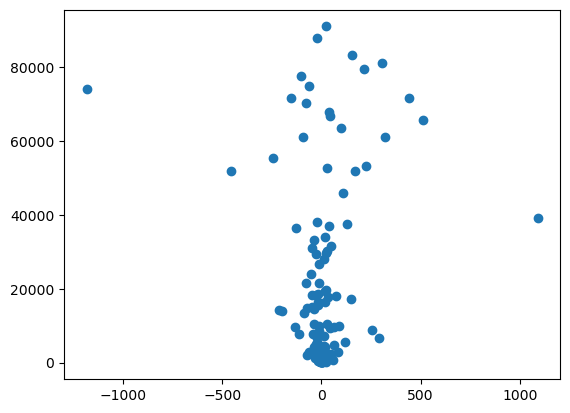

In [155]:
import matplotlib.pyplot as plt

plt.scatter(ms, Ns)
plt.show()

In [159]:
print(ms[0], ms[-1])

-1183 1089


In [169]:
len(ms)/(np.abs(ms[0])+ms[-1]+1)*100

np.float64(4.927408710954685)

In [160]:
import numpy as np
from tqdm import tqdm

# Compute the CDF

dm = 50
mranges = np.arange(ms[0], ms[-1], dm)
effs = []

for mrange in tqdm(mranges, desc='Computing efficiencies'):
    cnt = 0
    for m in ms:
        if m <= mrange:
            cnt += 1
    eff = cnt/len(ms)*100
    effs.append(eff)

Computing efficiencies: 100%|████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 37705.29it/s]


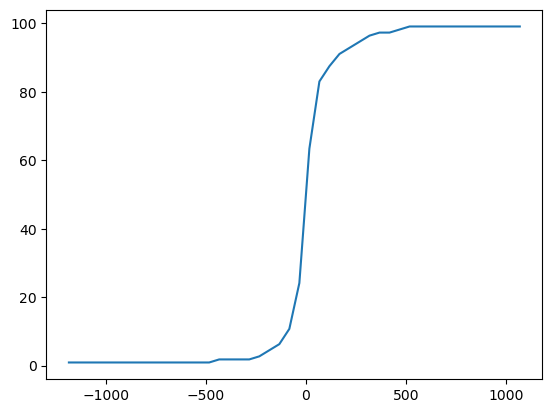

In [162]:
plt.plot(mranges, effs)
plt.show()

In [163]:
# This is the CDF, let's compute the pdf from it: df/dn

pdf = np.diff(effs)/np.array([dm]*(len(effs)-1))

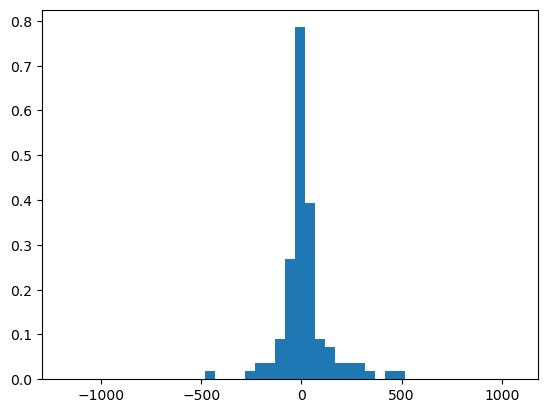

In [164]:
plt.stairs(pdf, mranges, fill=True, edgecolor='black')
plt.show()

Fit parameters: μ=0.022, γ=39.250, A=101.241
Reduced χ² = 0.005


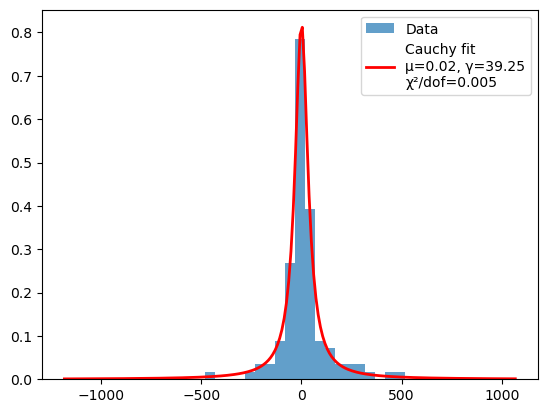

In [167]:
from scipy.optimize import curve_fit
import numpy as np

# Cauchy/Lorentzian PDF
def cauchy(x, A, mu, gamma):
    return A * (gamma / np.pi) / ((x - mu)**2 + gamma**2)

# Bin centers
x = np.array([(mranges[i] + mranges[i+1]) / 2 for i in range(len(mranges) - 1)])
pdf = np.array(pdf)

# Fit
p0 = [max(pdf), 0, 50]
bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])
popt, pcov = curve_fit(cauchy, x, pdf, p0=p0, bounds=bounds)
A, mu, gamma_param = popt

# Reduced chi-squared (uniform weighting)
residuals = pdf - cauchy(x, *popt)
dof = len(pdf) - len(popt)
chi2_red = np.sum(residuals**2) / (dof * np.var(pdf))

print(f"Fit parameters: μ={mu:.3f}, γ={gamma_param:.3f}, A={A:.3f}")
print(f"Reduced χ² = {chi2_red:.3f}")

# Plot
plt.stairs(pdf, mranges, fill=True, edgecolor='black', alpha=0.7, label='Data')
x_fit = np.linspace(mranges[0], mranges[-1], 200)
plt.plot(x_fit, cauchy(x_fit, *popt), 'r-', lw=2, 
         label=f'Cauchy fit\nμ={mu:.2f}, γ={gamma_param:.2f}\nχ²/dof={chi2_red:.3f}')
plt.legend()
plt.show()